In [18]:
 from sklearn.model_selection import StratifiedKFold
import math
import pandas as pd
import shutil
import time
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import os

In [19]:
paths = {
    'TRAIN_PATH' : os.path.join('workspace', 'images','kfold', 'train'),
    'TEST_PATH' : os.path.join('workspace', 'images','kfold','test'),
    'IMAGES_PATH': os.path.join('workspace','images','all'),
    'ANNOTATION_PATH': os.path.join('workspace','annotations'),
    'RESULTS_PATH': os.path.join('workspace','results')
 }

In [20]:
input_height = 69
input_width = 69
batch_size = 32

augmentation=False

In [56]:
K = 10

In [45]:
model_path = os.path.join("models","CNN_baseline_bigger_class_weights.h5")

In [23]:
def emptyFolders():
    if not os.path.exists(os.path.join(paths["TRAIN_PATH"])):
        os.makedirs(os.path.join(paths["TRAIN_PATH"]))
    if not os.path.exists(os.path.join(paths["TEST_PATH"])):
        os.makedirs(os.path.join(paths["TEST_PATH"]))
    for i in range(0,10):
        if not os.path.exists(os.path.join(paths["TRAIN_PATH"],str(i))):
            os.makedirs(os.path.join(paths["TRAIN_PATH"],str(i)))
        if not os.path.exists(os.path.join(paths["TEST_PATH"],str(i))):
            os.makedirs(os.path.join(paths["TEST_PATH"],str(i)))

        for file in os.listdir(os.path.join(paths["TRAIN_PATH"],str(i))):
            if file != ".DS_Store":
                os.remove(os.path.join(paths["TRAIN_PATH"],str(i), file))
        for file in os.listdir(os.path.join(paths["TEST_PATH"],str(i))):
            if file != ".DS_Store":
                os.remove(os.path.join(paths["TEST_PATH"],str(i), file))

df = pd.read_csv(os.path.join(paths['ANNOTATION_PATH'],"annotations.csv"))
df = df.dropna()

In [41]:
import random
import keras.utils as image
import matplotlib.pyplot as plt

def remove_images(label):
    img_names = os.listdir(os.path.join(paths['TRAIN_PATH'],str(label)))
    for image in img_names:  # Go over each image name to be deleted
      f = os.path.join(paths['TRAIN_PATH'],str(label),image)  # Create valid path to image
      os.remove(f)  # Remove the image

def undersample(label,n):
    img_names = os.listdir(os.path.join(paths['TRAIN_PATH'],str(label)))
    img_names = random.sample(img_names,n)  # Pick n random images to remove
    for image in img_names:  # Go over each image name to be deleted
      f = os.path.join(paths['TRAIN_PATH'],str(label),image)  # Create valid path to image
      os.remove(f)  # Remove the image

def augment_images(label,number_images, datagen):
    number_images = int(number_images)
    path = os.path.join(paths['TRAIN_PATH'],str(label))
    i = 0
    while i < number_images:
        for f in os.listdir(path):
          img = image.load_img(os.path.join(paths['TRAIN_PATH'],str(label),f), target_size=(69, 69))
          x = image.img_to_array(img)
          x = x.reshape((1,) + x.shape)
          for batch in datagen.flow(x, batch_size=1):
              new_image = image.array_to_img(batch[0])
              new_image.save(os.path.join(paths['TRAIN_PATH'],str(label),"aug_" + str(i) +".jpg"))
              i += 1
              if i > number_images:
                  return
              break

def renameDirectories():
    for i in range(6,10):
        os.rename(os.path.join(paths['TRAIN_PATH'],str(i)),os.path.join(paths['TRAIN_PATH'],str(i-1)))
        os.rename(os.path.join(paths['TEST_PATH'],str(i)),os.path.join(paths['TEST_PATH'],str(i-1)))

def rebalanceTrainingSet():
    CLASS_TO_DELETE = 5
    remove_images(CLASS_TO_DELETE)
    N_IMG_TO_DELETE = [2017,1551]
    CLASSES_TO_REDUCE = [1,2]
    for i in range(len(CLASSES_TO_REDUCE)):
        undersample(CLASSES_TO_REDUCE[i], N_IMG_TO_DELETE[i])
    CLASSES_TO_AUGMENT = [3,4,6,7,8,9]
    N_IMG_TO_AUGMENT = [600,400,600,500,500,600]

    datagen = ImageDataGenerator(
          rotation_range=40,
          width_shift_range=0.2,
          height_shift_range=0.1,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')

    for i in range(len(CLASSES_TO_AUGMENT)):
        augment_images(CLASSES_TO_AUGMENT[i], N_IMG_TO_AUGMENT[i], datagen)
    renameDirectories()

def plotTrainingDistribution():
    files_per_label = dict()
    for i in range(9):
      path = os.path.join(paths['TRAIN_PATH'],str(i))
      n_images = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
      files_per_label[i] = n_images
    plt.bar(list(files_per_label.keys()), files_per_label.values(), color='g')
    plt.show()
    print(files_per_label)
    return files_per_label

In [42]:
import keras
## Training with K-fold cross validation
kf = StratifiedKFold(n_splits=K, random_state=None, shuffle=False)

# TODO: change adapting to our project
df_new = pd.DataFrame()
for _, row in df.iterrows():
    if(row['Path'].endswith(".jpg")):
        new_row = { 'Path': row['Path'], 'Class': row['Class'] }
        df_new_row = pd.DataFrame([new_row])
        df_new = pd.concat([df_new, df_new_row],ignore_index=True)

print(df_new)
kf.get_n_splits(df_new)
df_results = pd.DataFrame()
i = 1
epochs=200

            Path  Class
0          0.jpg      2
1          1.jpg      2
2          2.jpg      4
3          3.jpg      2
4          4.jpg      4
...          ...    ...
21780  21780.jpg      2
21781  21781.jpg      1
21782  21782.jpg      2
21783  21783.jpg      9
21784  21784.jpg      2

[21785 rows x 2 columns]


In [55]:
import matplotlib.pyplot as plt
import keras.optimizers as optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras import models
from keras import regularizers
import math
import tensorflow as tf

import keras.backend as KB
# best loss function for multi-class classification, measures the distance between two probability distributions
# the probability distribution of the output of the network and the true distribution of the labels
loss_function='categorical_crossentropy'

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = KB.sum(KB.round(KB.clip(y_true * y_pred, 0, 1)))
    predicted_positives = KB.sum(KB.round(KB.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + KB.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = KB.sum(KB.round(KB.clip(y_true * y_pred, 0, 1)))
    possible_positives = KB.sum(KB.round(KB.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + KB.epsilon())
    return recall

metrics = [
    precision,
    recall,
    tf.keras.metrics.CategoricalAccuracy(name='acc')
]
optimizer='rmsprop'
optimizer_learning_rate=1e-4
epochs=100
batch_size=32
regularizer=regularizers.l1_l2(l1=0.001, l2=0.001) # simultaneous l1 and l2, add 0.001*weight_coefficient_value + 0.001 * 1/2*weight^2

if optimizer == 'rmsprop':
    optimizer=optimizers.RMSprop(learning_rate=optimizer_learning_rate)

# Function used to create the CNN structure used for regression
def create_cnn(width, height, depth, num_classes,filters=(16, 32, 64)):
    inputShape = (height, width, depth)
    chanDim = -1
    model = models.Sequential()
    for (i, f) in enumerate(filters):
        # first CONV layer set appropriately
        if i == 0:
            model.add(Conv2D(f, (3, 3), activation="relu", padding="same", input_shape=inputShape))
        else:
            model.add(Conv2D(f, (3, 3), activation="relu", padding="same"))
        # size of the patches typically 3x3 or 5x5
        # determine if we need to change padding or stride, with padding = same we are able to center convolutional windows around every input tile, in order to have always the same size of the input image
        # model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    # FLATTEN => FC => RELU => BN => DROPOUT
    model.add(Flatten())
    #model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu")) # consider if we need to add this dense layer before with more units, such as 64 in order to shrink in two different stages, depends on the outpout size of flatten
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Dense(num_classes, activation="softmax"))
    return model

model = create_cnn(input_width, input_height, 3, 9, (8,16))
model.summary()

# compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)
#try:
#    model = load_model(model_path, compile=True)
#except Exception as OSError:
#    pass

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 69, 69, 8)         224       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 34, 34, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 17, 17, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4624)              0         
                                                                 
 dense_6 (Dense)             (None, 64)               

Empty DataFrame
Columns: []
Index: []
====== K-Fold CV Iteration: 0/10 =======
Folders empty..
Train:  19606
Test:  2179
Images moved...


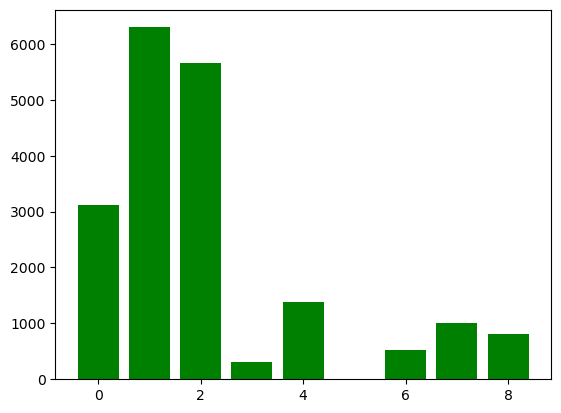

{0: 3115, 1: 6297, 2: 5662, 3: 314, 4: 1381, 5: 0, 6: 530, 7: 1009, 8: 816}


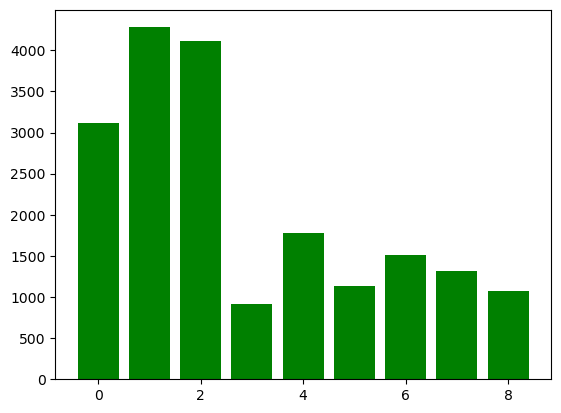

{0: 3115, 1: 4280, 2: 4111, 3: 915, 4: 1782, 5: 1131, 6: 1510, 7: 1317, 8: 1068}
Found 19229 images belonging to 9 classes.
Found 2177 images belonging to 9 classes.
19229
  1/601 [..............................] - ETA: 56s - loss: 0.8267 - precision: 0.7391 - recall: 0.5312 - acc: 0.6562

/var/folders/lp/fbpz2wyx1kb4b5zgt8w_tsp40000gn/T/ipykernel_11014/3687641812.py:76: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


601/601 [==============================] - 49s 82ms/step - loss: 0.8724 - precision: 0.7799 - recall: 0.5626 - acc: 0.6817 - val_loss: 0.7747 - val_precision: 0.8260 - val_recall: 0.5987 - val_acc: 0.7308 - lr: 1.0000e-04
       model  k  epoch       acc  test_acc  test_recall  test_precision
0  optimized  0      1  0.681731  0.730822     0.598732        0.826042
====== K-Fold CV Iteration: 1/10 =======
Folders empty..
Train:  19606
Test:  2179


KeyboardInterrupt: 

In [66]:
df_results = pd.DataFrame()
print(df_results)
i = 0
epochs = 1
for train_index, test_index in kf.split(df_new, df_new['Class']):
    print("====== K-Fold CV Iteration: %d/%d =======" % (i,K))
    emptyFolders()
    print("Folders empty..")

    print("Train: ", len(train_index))
    print("Test: ", len(test_index))

    df_train = df_new.iloc[train_index]
    df_test = df_new.iloc[test_index]


    for _, row in df_train.iterrows():
        try:
            shutil.copy(os.path.join(paths["IMAGES_PATH"],row['Path']),
                    os.path.join(paths["TRAIN_PATH"],str(row['Class']),row['Path']))
        except:
            pass
    for _, row in df_test.iterrows():
        try:
            shutil.copy(os.path.join(paths["IMAGES_PATH"],row['Path']),
                    os.path.join(paths["TEST_PATH"],str(row['Class']),row['Path']))
        except:
            pass
    print("Images moved...")
    plotTrainingDistribution()
    rebalanceTrainingSet()
    files_per_label = plotTrainingDistribution()
    time.sleep(10)
    train_datagen = ImageDataGenerator(rescale=1./255)

    train_dir=paths['TRAIN_PATH']
    # TODO: Consider if the output should be normalized
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

    # validation set image data generator
    val_datagen = ImageDataGenerator(rescale=1./255) # it should not be augmented
    validation_dir=paths['TEST_PATH']
    validation_generator = val_datagen.flow_from_directory(validation_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')


    #number of classes
    NUM_CLASSES = 9

    #get number of total images
    tot_images = sum(list(files_per_label.values()))
    print(tot_images)

    weights = dict([ (class_label , tot_images/(NUM_CLASSES * n_images)) for class_label, n_images in files_per_label.items()])

    n_images_eval = 0
    for j in range(9):
        path = os.path.join(paths['TEST_PATH'],str(j))
        #compute number of images in each eval folder and sum it up
        n_images_eval = n_images_eval + len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])

    number_training = tot_images # TODO: contare elementi training cartella
    number_eval = n_images_eval

    callbacks_list = [
        keras.callbacks.EarlyStopping(
            monitor='acc', # should be part of the metrics specific during compilation
            patience=5,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2, # divides LR by 5 when triggered
            patience=3 # called when stopped improving for 3 epochs
        ),
    ]

    history = model.fit_generator(
      train_generator,
      steps_per_epoch=int(math.ceil((1. * number_training) / batch_size)),
      epochs=epochs,
      validation_data=validation_generator,
      callbacks=callbacks_list,
      validation_steps=int(math.ceil((1. * number_eval) / batch_size)))

    acc = history.history['acc'][epochs-1]
    val_acc = history.history['val_acc'][epochs-1]
    val_recall = history.history['val_recall'][epochs-1]
    val_precision = history.history['val_precision'][epochs-1]
    new_row = { 'model': 'optimized', 'k': i+1, 'epochs': epochs, 'acc': acc, 'test_acc': val_acc, 'test_recall': val_recall, 'test_precision': val_precision}
    df_new_row = pd.DataFrame([new_row])
    df_results = pd.concat([df_results, df_new_row],ignore_index=True)

    #model.save(model_path)
    i+=1

    print(df_results)

In [37]:
df_results.to_csv(os.path.join(paths['RESULTS_PATH'], "resultsKFold.csv"), index=False)